In [1]:
import requests
from dotenv import load_dotenv
import os
from PIL import Image, ImageDraw

load_dotenv();

In [2]:
image_path = "documentation\photo_1.jpg"

In [3]:
def query_caption(filename):
    API_URL = "https://api-inference.huggingface.co/models/Salesforce/blip-image-captioning-large"
    headers = {"Authorization": "Bearer " + os.environ['HUGGINGFACEHUB_API_TOKEN']}

    with open(filename, "rb") as f:
        data = f.read()
    response = requests.post(API_URL, headers=headers, data=data)
    return response.json()


In [4]:
query_caption(image_path)[0]

{'generated_text': 'there is a woman sitting in a hammock with a dog'}

In [5]:
def object_detection_query(filename):
    API_URL = "https://api-inference.huggingface.co/models/facebook/detr-resnet-50"
    headers = {"Authorization": "Bearer " + os.environ['HUGGINGFACEHUB_API_TOKEN']}
    with open(filename, "rb") as f:
        data = f.read()
    response = requests.post(API_URL, headers=headers, data=data)
    return response.json()

In [6]:
output = object_detection_query(image_path)

In [7]:
detections = ""
for result in output:
    box = result['box']
    detections += '[{}, {}, {}, {}]'.format(int(box['xmin']), int(box['ymin']), int(box['xmax']), int(box['ymax']))
    detections += ' {}'.format(result['label'])
    detections += ' {}\n'.format(result['score'])

In [8]:
detections

'[243, 212, 266, 240] cup 0.9958415627479553\n[113, 251, 269, 407] dog 0.9996066689491272\n[14, 232, 141, 406] chair 0.9446659088134766\n[238, 150, 390, 404] person 0.9992550015449524\n'

In [9]:
output

[{'score': 0.9958415627479553,
  'label': 'cup',
  'box': {'xmin': 243, 'ymin': 212, 'xmax': 266, 'ymax': 240}},
 {'score': 0.9996066689491272,
  'label': 'dog',
  'box': {'xmin': 113, 'ymin': 251, 'xmax': 269, 'ymax': 407}},
 {'score': 0.9446659088134766,
  'label': 'chair',
  'box': {'xmin': 14, 'ymin': 232, 'xmax': 141, 'ymax': 406}},
 {'score': 0.9992550015449524,
  'label': 'person',
  'box': {'xmin': 238, 'ymin': 150, 'xmax': 390, 'ymax': 404}}]

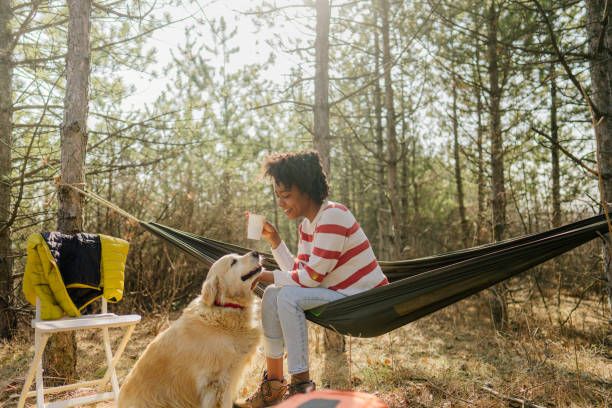

In [10]:
Image.open(image_path).convert('RGB')

In [11]:
def bounding_box(image_path):
    output = object_detection_query(image_path)

    # Load the image
    image = Image.open(image_path).convert('RGB')

    # Create a drawing object
    draw = ImageDraw.Draw(image)

    # Draw boxes and labels on the image
    for detection in output:
        label = detection['label']
        score = detection['score']
        box = detection['box']

        # Draw the box
        draw.rectangle([box['xmin'], box['ymin'], box['xmax'], box['ymax']], outline="red", width=2)

        # Draw the label and score
        text = f"{label} ({score:.2f})"
        draw.text((box['xmin'], box['ymin']-10), text, fill='red')

    return image

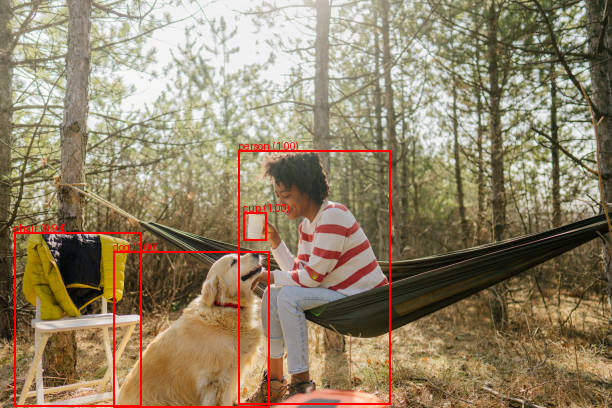

In [12]:
bounding_box(image_path)

In [13]:
import os
dir_path = './temp'

In [14]:
os.listdir(dir_path)

[]

In [15]:
for filename in os.listdir(dir_path):
    file_path = os.path.join(dir_path, filename)
    print(file_path)
    if os.path.isfile(file_path):
        os.unlink(file_path)

In [16]:
from function import ImageCaptionTools, ObjectDetectionTool
from langchain.agents import initialize_agent, AgentType
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.memory import ConversationBufferMemory

d:\Code Workspace\Personal Project\Personal Project - LangChain Project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
llm = ChatGoogleGenerativeAI(model = "gemini-pro")
tools = [ImageCaptionTools(), ObjectDetectionTool()]
memory = ConversationBufferMemory(memory_key="chat_history", return_messages= True)

In [22]:
agents = initialize_agent(
    agent = AgentType.CONVERSATIONAL_REACT_DESCRIPTION,
    llm = llm,
    tools= tools,
    max_iterations = 5,
    verbose = True,
    memory = memory
)

In [23]:
user_question = "can you detect any object and their location in this image?"

response = agents.invoke({"input": f"{user_question}, this is the image path: {image_path}"})



> Entering new AgentExecutor chain...
Thought: Do I need to use a tool? Yes
Action: Object_Detection_Tool
Action Input: documentation\photo_1.jpg
Observation: [243, 212, 266, 240] cup 0.9958415627479553
[113, 251, 269, 407] dog 0.9996066689491272
[14, 232, 141, 406] chair 0.9446659088134766
[238, 150, 390, 404] person 0.9992550015449524

Thought:Do I need to use a tool? No
AI: The image detection has found a cup, a dog, a chair and a person in the image. The cup is located at the top right corner, the dog is in the middle-right, the chair is on the left, and the person is in the middle of the image.

> Finished chain.


In [168]:
response['output']

"In a tranquil embrace, amidst nature's art,\nA woman and her furry friend find solace apart.\nBound by love's tender thread, their spirits entwine,\nIn this haven of peace, where happiness does shine.\n\nWith joy in their eyes, companions so true,\nThey share a bond unbreakable, old or new.\nThrough laughter and tears, they'll forever be,\nA testament to love and harmony.\n\nIn this symphony of life, their souls dance with glee,\nAs nature's orchestra plays its sweet melody.\nUnited in purpose, they chase dreams hand in hand,\nIn this sacred sanctuary, they'll forever stand.\n\nLike a tapestry woven with love's golden thread,\nTheir story unfolds, a tale to be spread.\nThrough highs and through lows, they'll face life's test,\nWith unwavering devotion, their love will be blessed."

In [24]:
response

{'input': 'can you detect any object and their location in this image?, this is the image path: documentation\\photo_1.jpg',
 'chat_history': [HumanMessage(content='can you detect any object and their location in this image?, this is the image path: documentation\\photo_1.jpg'),
  AIMessage(content='The image detection has found a cup, a dog, a chair and a person in the image. The cup is located at the top right corner, the dog is in the middle-right, the chair is on the left, and the person is in the middle of the image.')],
 'output': 'The image detection has found a cup, a dog, a chair and a person in the image. The cup is located at the top right corner, the dog is in the middle-right, the chair is on the left, and the person is in the middle of the image.'}